Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

$\Lambda_1^E \left(\begin{bmatrix} x\\y \\0\end{bmatrix}\right) = \begin{bmatrix}x \\y \\0 \end{bmatrix}$

In [1]:
import numpy, scipy, pandas, itertools
import matplotlib.pyplot as plt

# side-by side display of pandas data frames
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

/usr/lib64/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/lib64/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/lib64/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/lib64/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/lib64/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility

In [225]:
# define the Triangle element class with methods

class Triangle:
    def __init__(self,a,b,c):

        # initialize the vertices
        self.a = numpy.array(a)
        self.b = numpy.array(b)
        self.c = numpy.array(c)
        
        # define the Jacobian and its inverse
        col1 = self.a - self.c
        col2 = self.b - self.c
        col3 = numpy.cross(col1,col2)
        self.Jac = numpy.array([col1,col2,col3]).T
        self.JacInv = numpy.linalg.inv(self.Jac)
        self.J = numpy.linalg.norm(col3)

        self.area = self.J/2
        
        # initialize the quadrature points
        self.qp = []
        self.n = 0
        
    # get map from reference to this triangle
    def refToPhys(self,point):
        return numpy.dot(self.Jac, numpy.array([point[0],point[1],0])) + self.c
    
    # plot the triangle
    def plotElement(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*self.a)
        ax.scatter(*self.b)
        ax.scatter(*self.c)
        #from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        #poly3d = [1,0,0]
        #ax.add_collection3d(Poly3DCollection(poly3d, facecolors=['blue'], linewidths=1))
        plt.show()

    def setUniformQP(self,n):
        self.n = n
        refQP = [numpy.array([j+0.5,n+.5-i],float)/n for i in range(n+1) for j in range(i)]
        self.qp = [self.refToPhys(point) for point in refQP]
        return len(self.qp)
        
    def plotQP(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        [ax.scatter(*point) for point in self.qp]
        plt.show()
        
    def coordsDuffy(self,t):
        t1 = t[0]
        t2 = t[1]
        return numpy.array((1.-(t1+1.)/2.)*self.c + \
                           (t1+1.)/2. * (1.- (t2+1.)/2.)*self.a + \
                           (t1+1.)*(t2+1.)*self.b/4.)

In [200]:
# kernels

# weakly singular
def g(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

# strongly singular, coordinate-wise
def gradgx(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[0]-rp[0]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradgy(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[1]-rp[1]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradgz(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[2]-rp[2]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

In [244]:
# integrate g(r,r')*div(\Lambda_1) via uniform midpoint rule
def approxUniform(T,g,rp,n,k=1):
    T.setUniformQP(n)
    value = 0.0
    for point in T.qp:
        testA = point - T.a
        testB = point - T.b
        testA = testA/numpy.linalg.norm(testA)
        testB = testB/numpy.linalg.norm(testB)
        weight = 0.0
        if numpy.dot(testA,testB) == 1. or numpy.dot(testA,testB) == -1.:
            weight = 2.*n*n
        else:
            weight = n*n
        value += g(point,rp,k)*\
            (T.JacInv[1][1] + T.JacInv[2][2])*\
            T.J/weight
    return value

# Duffy transform approximation
def approxDuffy(T,g,rp,n,k=1):
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += g(D.coordsDuffy([t1,t2]),rp,k)*\
                (T.JacInv[1][1] + T.JacInv[2][2])*\
                T.J*(t1+1.)/4.*D.area * tensorweight
    return  value

In [202]:
# Duffy transform and singularity extraction approximation
def approxDuffySingEx(T,g,rp,n,k=1):
    dxp_dt1 = lambda (t1,t2) = 
    dyp_dt1 = lambda (t1,t2) = 
    dzp_dt1 = lambda (t1,t2) = 
    fkcubed = lambda t2 = numpy.power(numpy.power(dxp_dt1((-1,t2)),2)+\
                                      numpy.power(dyp_dt1((-1,t2)),2)+\
                                      numpy.power(dzp_dt1((-1,t2)),2),0.5)
    # regular part
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += D.area * 1./(16.*numpy.pi)*\
                ((1./t1+1 fkcubed(t2))*dxp_dt1(-1,t2) - g(D.coordsDuffy([t1,t2]),rp,k))*\
                    (T.JacInv[1][1] + T.JacInv[2][2])*\
                    T.J*tensorweight
    # singular part
    for D in [D1, D2, D3]:
        value += -1./(16.*numpy.pi)*
    return value

SyntaxError: invalid syntax (<ipython-input-202-4266c73769bb>, line 3)

In [203]:
# test the Duffy transform
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)

print '(-1,-1) got mapped to',T.coordsDuffy((-1,-1))
print '(-1, 0) got mapped to',T.coordsDuffy((-1,0))
print '(-1,+1) got mapped to',T.coordsDuffy((-1,1))

print '(+1,-1) got mapped to',T.coordsDuffy((1,-1))
print '(+1, 0) got mapped to',T.coordsDuffy((1,0))
print '(+1,+1) got mapped to',T.coordsDuffy((1,1))

print 'area is',T.area

(-1,-1) got mapped to [0. 1. 5.]
(-1, 0) got mapped to [0. 1. 5.]
(-1,+1) got mapped to [0. 1. 5.]
(+1,-1) got mapped to [1. 1. 5.]
(+1, 0) got mapped to [0.5 1.5 5. ]
(+1,+1) got mapped to [0. 2. 5.]
area is 0.5


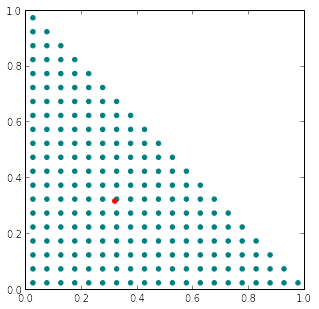

In [204]:
%matplotlib inline
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))

T.setUniformQP(20)
plt.figure(figsize=(5,5))
for point in T.qp:
    plt.scatter(point[0],point[1],color='teal')
plt.scatter(rp[0],rp[1],color='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

#### test under translation and rotation

In [241]:
# apply the uniform midpoint rule for approximation
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
T = Triangle(A,B,C)
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [245]:
T.JacInv

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [248]:
# check the result under the translation y+=1, z+=5
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest1 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest1.columns = ['Unif Real', 'Unif Imag']
dataUniformTest1.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [249]:
T.JacInv

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [252]:
# check the result under a rotation
A = (0,0,1)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest2 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest2.columns = ['Unif Real', 'Unif Imag']
dataUniformTest2.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [255]:
T.Jac

array([[ 0,  0, -1],
       [ 0,  1,  0],
       [ 1,  0,  0]])

In [230]:
display(dataUniform)
display(dataUniformTest1)
display(dataUniformTest2)

,Unif Real,Unif Imag
1,0.599069,-0.157409
120,0.366990,-0.080493
435,0.369384,-0.079293
946,0.373599,-0.078655
1653,0.369015,-0.078557
2628,0.369615,-0.078527
3741,0.375913,-0.078359
5050,0.370567,-0.078388
6555,0.372164,-0.078395
8256,0.371913,-0.078467


,Unif Real,Unif Imag
1,0.599069,-0.157409
120,0.366369,-0.080168
435,0.370436,-0.079489
946,0.374067,-0.078861
1653,0.369159,-0.078584
2628,0.369673,-0.078557
3741,0.375945,-0.078360
5050,0.370602,-0.078396
6555,0.372057,-0.078348
8256,0.371913,-0.078467


,Unif Real,Unif Imag
1,0.299534,-0.078705
3,0.246215,-0.039130
6,0.160359,-0.043462
15,0.253850,-0.040642
21,0.165812,-0.039065
28,0.182719,-0.041461
45,0.176361,-0.040455
55,0.176075,-0.039059
66,3.794213,-0.041261
91,0.181491,-0.040656


In [140]:
# apply the uniform midpoint rule for approximation
A = (.1,0,0)
B = (0,.1,0)
C = (0,0,.1)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
T = Triangle(A,B,C)
maxLevel = 200
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [141]:
# apply the Duffy transform for approximation
A = (.1,0,0)
B = (0,.1,0)
C = (0,0,.1)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
T = Triangle(A,B,C)
maxLevel = 30
steps = 15

results = [approxDuffy(T,g,rp,int(i)) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [142]:
display(dataUniform)
display(dataDuffy)

,Unif Real,Unif Imag
1,0.128802,-0.053710
120,0.064645,-0.028560
435,0.062572,-0.027696
946,0.061851,-0.027394
1653,0.061484,-0.027241
2628,0.061250,-0.027143
3741,0.061105,-0.027082
5050,0.061001,-0.027038
6555,0.060922,-0.027005
8256,0.060861,-0.026980


,Duffy Real,Duffy Imag
3,0.015428,-0.000751
27,0.016887,-0.000751
75,0.017230,-0.000751
147,0.017362,-0.000751
243,0.017426,-0.000751
363,0.017462,-0.000751
507,0.017484,-0.000751
675,0.017498,-0.000751
867,0.017508,-0.000751
1083,0.017515,-0.000751


In [11]:
# that required this many quadrature points
n=20 # for uniform
print 'unif  approx:',len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]),\
    'with approx value', approxUniform(T,g,rp,n)
n = 8 # for Duffy
print 'Duffy approx:',3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2,\
    'with approx value', approxDuffy(T,g,rp,n)

unif  approx: 210 with approx value (0.0061171785024941305+0.014739807695383685j)
Duffy approx: 192 with approx value (-0.10256995349755756-0.06428912918493428j)


In [12]:
%%timeit
n=20
approxUniform(T,g,rp,n)

100 loops, best of 3: 5.43 ms per loop


In [13]:
%%timeit
n=8
approxDuffy(T,g,rp,n)

100 loops, best of 3: 4.71 ms per loop


### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

In [30]:
A = (0.2,0,0)
B = (0,0.2,0)
C = (0,0,0.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi,0))

freqHz  = 30e6;
eps0    = 8.85418781761e-12;
mu0     = numpy.pi*4e-7;
c_light = 1./numpy.sqrt(eps0*mu0);
wavelength  = c_light/freqHz;
#eta     = numpy.sqrt(mu0/eps0);
#omega   = 2*numpy.pi*freqHz;
k0      = 2.*numpy.pi/wavelength;

### x- component

In [15]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps = 15
results = [approxUniform(T,gradgx,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [31]:
# apply the Duffy transform for approximation

maxLevel = 100
steps = 15
results = [approxDuffy(T,gradgx,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [32]:
# apply the Duffy transform for approximation

maxLevel = 100
steps = 15
results = [approxDuffySingEx(T,gradgx,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffySing = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffySing.columns = ['Duf & SingEx Real part', 'Duf & SingEx Imag']
dataDuffySing.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [33]:
display(dataUniform)
display(dataDuffy)
display(dataDuffySing)

,Unif Real,Unif Imag
1,-77.158437,1.530972
120,25.239078,-0.015415
435,-27.276904,0.033673
946,66.567918,-0.018385
1653,-10.769856,0.011759
2628,5.252988,0.003468
3741,-157.551140,0.027839
5050,14.635869,0.000446
6555,-49.271615,0.012013
8256,35.723522,-0.002516


,Duffy Real part,Duffy Imag
3,0.541485,-0.006889
192,2.225670,-0.016546
675,3.000997,-0.017069
1452,3.502151,-0.017201
2523,3.872632,-0.017253
3888,4.166566,-0.017279
5547,4.410195,-0.017294
7500,4.618232,-0.017303
9747,4.799757,-0.017309
12288,4.960766,-0.017313


,Duf & SingEx Real part,Duf & SingEx Imag
3,0.541485,-0.006889
192,2.225670,-0.016546
675,3.000997,-0.017069
1452,3.502151,-0.017201
2523,3.872632,-0.017253
3888,4.166566,-0.017279
5547,4.410195,-0.017294
7500,4.618232,-0.017303
9747,4.799757,-0.017309
12288,4.960766,-0.017313


### y- component

In [18]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps=15
results = [approxUniform(T,gradgy,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

# apply the Duffy transform for approximation
maxLevel = 100
steps=15
results = [approxDuffy(T,gradgy,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [19]:
display(dataUniform)
display(dataDuffy)

,Unif Real,Unif Imag
1,-192.896092,3.827429
120,63.097695,-0.038537
435,-68.192261,0.084184
946,166.419796,-0.045962
1653,-26.924639,0.029396
2628,13.132470,0.008671
3741,-393.877850,0.069599
5050,36.589673,0.001114
6555,-123.179038,0.030033
8256,89.308806,-0.006291


,Duffy Real part,Duffy Imag
3,0.314233,-0.005530
192,2.212219,-0.016540
675,2.996581,-0.017068
1452,3.499980,-0.017201
2523,3.871344,-0.017253
3888,4.165715,-0.017279
5547,4.409590,-0.017294
7500,4.617781,-0.017303
9747,4.799408,-0.017309
12288,4.960487,-0.017313


### z- component

In [20]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps=15
results = [approxUniform(T,gradgz,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

# apply the Duffy transform for approximation
maxLevel = 100
steps=15
results = [approxDuffy(T,gradgz,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [21]:
display(dataUniform)
display(dataDuffy)

,Unif Real,Unif Imag
1,-77.158437,1.530972
120,25.239078,-0.015415
435,-27.276904,0.033673
946,66.567918,-0.018385
1653,-10.769856,0.011759
2628,5.252988,0.003468
3741,-157.551140,0.027839
5050,14.635869,0.000446
6555,-49.271615,0.012013
8256,35.723522,-0.002516


,Duffy Real,Duffy Imag
3,4.774225,-0.146395
192,11.339466,-0.155750
675,14.126202,-0.156173
1452,15.914053,-0.156277
2523,17.232753,-0.156318
3888,18.277962,-0.156339
5547,19.143842,-0.156350
7500,19.883003,-0.156357
9747,20.527838,-0.156362
12288,21.099719,-0.156365
